## Welcome to Bayes' Battle Bots
This is a notebook to flesh out a model for Bayesian updating. It might get moved into scripts eventually

*Use auc to normalize scale the posterior so that the cdf sums to 1. 

*All the bayesian code already exists in a jupyter notebook on your laptop called Sand. Transfer it over. 

In [596]:
## Load required packages
import numpy as np

from math import comb
import itertools,random

from scipy.special import rel_entr
from scipy.stats import mode
from scipy.stats import norm

from sklearn.metrics import auc

import matplotlib.pyplot as plt
from matplotlib import cm

/tmp/ipykernel_7584/3191643794.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_7584/3191643794.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


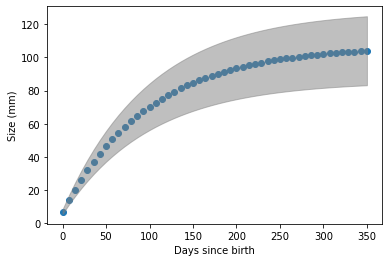

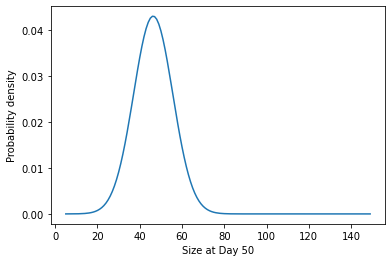

In [648]:
## Prior function


def prior_size(t,xs = np.arange(5,150)):
    s_mean = growth_func(t)
    sd = s_mean / 5
    return norm.pdf(xs,s_mean,sd)

def growth_func(t,s_max = 100):
    size = 7 + s_max - s_max/np.exp(t/100)
    return size



fig,ax = plt.subplots()
ts = np.linspace(0,350)

ax.scatter(ts,growth_func(ts))
ax.fill_between(ts,growth_func(ts)-growth_func(ts)/5,growth_func(ts)+growth_func(ts)/5,color='gray',alpha=.5)
ax.set_xlabel('Days since birth')
ax.set_ylabel('Size (mm)')
fig.show()

fig,ax = plt.subplots()

t = 50
ax.plot(np.arange(5,150),prior_size(t))
ax.set_xlabel('Size at Day 50')
ax.set_ylabel('Probability density')
fig.show()

/tmp/ipykernel_7584/3813859319.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


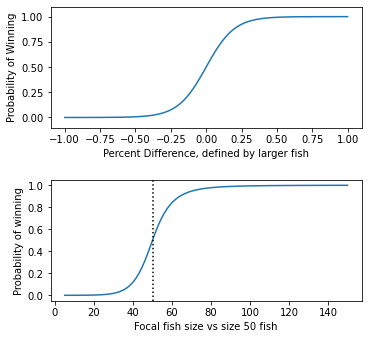

In [660]:
## Likelihood function

def win_by_ratio(r, k=0.1,m=0):
    # sigmoid function
    # use k to adjust the slope
    p = 1 / (1 + np.exp(-(r-m) / k)) 
    return p

def likelihood_function_size(x,x_opp=50):
    if x >=x_opp:
        r_diff = (x - x_opp)/x # Will be positive
    elif x_opp > x:
        r_diff = (x - x_opp)/x_opp # Will be negative
    p_win = win_by_ratio(r_diff)
    return p_win
    
def define_likelihood(x_opp=50,xs=np.arange(5,150),win=True):
    likelihood = np.zeros(len(xs))
    if win:
        for s in range(len(xs)):
            likelihood[s] = likelihood_function_size(xs[s],x_opp)
    elif not win:
        for s in range(len(xs)):
            likelihood[s] = 1-likelihood_function_size(xs[s],x_opp)
    return likelihood


fig,(ax,ax1) =plt.subplots(2)

xs = np.linspace(-1,1,100)
ax.plot(xs,win_by_ratio(xs))
ax.set_xlabel('Percent Difference, defined by larger fish')
ax.set_ylabel('Probability of Winning')
ax.set_ylim(-0.1,1.1)


xs1 = np.linspace(5,150,100)
ys1 = []
for x in xs1:
    ys1.append(likelihood_function_size(x))
ax1.plot(xs1,ys1)
ax1.axvline(50,color='black',linestyle=':')
ax1.set_xlabel('Focal fish size vs size 50 fish')
ax1. set_ylabel('Probability of winning')
fig.tight_layout()
fig.set_size_inches([5,5])
fig.show()



/tmp/ipykernel_7584/3986303736.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


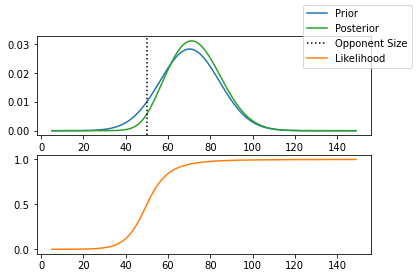

In [667]:
## Update a prior by a likelihood

## xs need to be the same for prior, likelihood, and post
def update(prior,likelihood,xs = np.arange(5,150)):
    post = prior * likelihood
    post = post / auc(xs,post)
    return post

xs = np.arange(5,150)
t = 100
x_opp = 50
win = True
prior = prior_size(t,xs)

likelihood = define_likelihood(x_opp,win=win)
    
posterior = update(prior,likelihood)

fig,(ax1,ax2) = plt.subplots(2)
ax1.plot(xs,prior,label='Prior')
ax2.plot(xs,likelihood,label='Likelihood',color='tab:orange')
ax1.plot(xs,posterior,label='Posterior',color='tab:green')
ax1.axvline(50,color='black',linestyle=':',label='Opponent Size')
fig.legend()
fig.show()

Estimated size: 46.2625250501002
(46.347098715100024, 9.26901817693628)
Fight? True
My name is: Phil
Actual size: 49.249769565057406
Size estimate: 21.56312625250501
Win record: [[20, False]]
Fight? False
Win? True
Win fixed? True
3.441479982289194
119.8536868276933 10.947770861124802
(31.046591901630855, 10.947770861124802)


/tmp/ipykernel_7584/2851097327.py:134: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


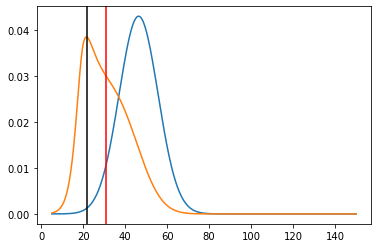

In [789]:
## Define a fish object

class Fish:
    def __init__(self,name=0,age=50,size=None,prior=None,likelihood=None,xs=np.linspace(5,150,500)):
        self.name = name
        self.age = age
        self.xs = xs
        if size is not None:
            if size == 0:   
                self.size = growth_func(self.age)
            else:
                self.size = size
        else:
            mean = growth_func(self.age)
            sd = mean/5
            self.size = np.random.normal(mean,sd)
        if prior is not None:
            self.prior = pior
        else:
            self.prior = self._prior_size(self.age,xs=self.xs)
        
        self.estimate = self.xs[np.argmax(self.prior)]
        prior_mean,prior_std = self.get_stats()
        self.estimate_ = prior_mean
        self.win_record = []
        self.est_record = [self.estimate]
        self.est_record_ = [self.estimate_]
        self.sdest_record = [prior_std]
        
    def _update(self,prior,likelihood,xs = None):
        if xs is None:
            xs = self.xs
        post = prior * likelihood
        post = post / auc(xs,post)
        return post
    
    def _prior_size(self,t,xs = np.arange(5,150)):
        s_mean = self._growth_func(t)
        sd = s_mean / 5
        return norm.pdf(xs,s_mean,sd)

    def _growth_func(self,t,s_max = 100):
        size = 7 + s_max - s_max/np.exp(t/100)
        return size
    
    
    def update_prior(self,win,x_opp,xs=None):
        if xs is None:
            xs = self.xs
        likelihood = define_likelihood(x_opp,xs,win)
        self.win_record.append([x_opp,win])
        self.prior = self._update(self.prior,likelihood,xs)
        if True: ## Need to decide which of these to use...
            estimate = self.xs[np.argmax(self.prior)] ## This is easy, but should it be the mean?
        else:
            estimate = np.sum(self.prior * self.xs / np.sum(self.prior))
        self.estimate_ = np.sum(self.prior * self.xs / np.sum(self.prior))
        
        prior_mean,prior_std = self.get_stats()
        self.est_record_.append(prior_mean)
        self.sdest_record.append(prior_std)
        
        self.estimate = estimate
        self.est_record.append(estimate)
        
        return self.prior,self.estimate
    
    def plot_prior(self,ax=None):
        if ax is None:
            fig,ax = plt.subplots()
        ax.plot(self.xs,self.prior)
        if ax is None:
            fig.show()
    def summary(self): # print off a summary of the fish
        print('My name is:',self.name)
        print('Actual size:',self.size)
        print('Size estimate:',self.estimate)
        print('Win record:',self.win_record)
        return self.name,self.size,self.estimate,self.win_record
    
    def escalate(self,x_opp): # Decide whether to fight (or escalate a fight) against a bigger fish
        #print('Choosing whether to escalate...Estimate,opponent:',self.estimate,x_opp)
        if self.estimate > x_opp:
            return True
        else:
            return False
    
    def fight(self,x_opp): # Decide if you win against another fish
        prob_win = likelihood_function_size(self.size,x_opp)
        roll = np.random.random()
        if roll < prob_win: # This should be right, >= would bias it, < is fair I think
            return True
        else:
            return False
    def fight_fixed(self,x_opp): # Same as above, but the bigger fish always wins
        if self.size > x_opp:
            return True
        else:
            return False
    def get_stats(self):
        prior_mean = np.sum(self.prior * self.xs / np.sum(self.prior))
        prior_std = np.sum((self.xs - prior_mean)**2 * self.prior/(np.sum(self.prior)))
        prior_std = np.sqrt(prior_std)
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        
        return prior_mean,prior_std
        
        
f1 = Fish('Phil',age=50)
print('Estimated size:',f1.estimate)
print(f1.get_stats())
print('Fight?',f1.escalate(38))
fig,ax = plt.subplots()
f1.plot_prior(ax)
f1.update_prior(win=False,x_opp=20)
f1.plot_prior(ax)
#ax.plot(f1.xs,f1.prior * f1.xs,color='black')


_ = f1.summary()

print('Fight?',f1.escalate(40))
print('Win?',f1.fight(40))
print('Win fixed?',f1.fight_fixed(40))

print(np.sum(f1.prior))

prior_mean = np.sum(f1.prior * f1.xs / np.sum(f1.prior))
prior_std = np.sum((f1.xs - prior_mean)**2 * f1.prior/(np.sum(f1.prior)))
ax.axvline(prior_mean,color='red')
ax.axvline(f1.estimate,color='black')

fig.show()
print(prior_std,np.sqrt(prior_std))
print(f1.get_stats())

In [844]:
## Define a long-term tank class:

## Fight is a dictionary or maybe class:
#Fish 1 vs Fish 2
#Winner: Fish 2
#Extent: None

## Super simple object to keep track of matchups (and decide outcome if necessary)


class Fight():
    def __init__(self,fish1,fish2,outcome="chance",level=None):
        self.fish1 = fish1
        self.fish2 = fish2
        self.fishes = [fish1,fish2]
        self.mechanism = outcome
        self.level = level
        self.outcome = '?'
        
    def run_outcome(self):
        if self.mechanism == 'chance':
            self.outcome = self.chance_outcome()
        elif self.mechanism == 'escalate':
            self.outcome,self.level = self.escalating_outcome()
        else:
            self.outcome = self.mechanism
      
        self.winner = self.fishes[self.outcome]
        self.loser = self.fishes[1-self.outcome]
        
    def chance_outcome(self): ## This just pulls from the fish.fight, basically a dice roll vs the likelihood
        prob_win = likelihood_function_size(self.fish1.size,self.fish2.size)
        self.prob_win = prob_win
        if np.random.random() < prob_win:
            return 0
        else:
            return 1
    
    def escalating_outcome(self):
        cont = True
        level = 0
        focal_fish = np.random.choice([0,1])
        while cont and level < 3:
            focal_fish = 1-focal_fish  ## define the focal fish
            other_fish = 1-focal_fish  ## The other fish is defined as the other fish
            cont = self.fishes[focal_fish].escalate(self.fishes[other_fish].size)
            if cont == True:
                level += 1
            else:
                return 1-focal_fish,level
        ## IF you escalate to 3, return the winner based on likelihood curve
        winner = self.chance_outcome()
        return winner,level
            
    def summary(self):
        prob_outcome = self.prob_win
        if self.outcome:
            prob_outcome = 1 - prob_outcome
        
        return ' '.join([str(self.fish1.name),'vs',str(self.fish2.name),str(self.outcome),': So,',str(self.winner.name),'won, with probability',str(prob_outcome)])


class Tank():
    def __init__(self,fishes,fight_list = None,n_fights = None,f_method='balanced',f_outcome='chance'):
        self.fishes = fishes
        self.f_method = f_method
        self.f_outcome = f_outcome
        if fight_list is not None:
            self.fight_list = fight_list
        else:
            if n_fights is None:
                ## if n is not defined, just run each one once
                self.fight_list = self.get_matchups(f_method,f_outcome)
                self.n_fights = len(self.fight_list)
            else:
                self.fight_list = self.get_matchups(f_method,f_outcome,n_fights)
            
            ## Randomly match up fishes
    
    def get_matchups(self,f_method='balanced',f_outcome='chance',n_fights=10):
        fight_list = []
        
        if f_method == 'balanced':
            short_list = []
            for i in range(n_fights):
                for f1,f2 in itertools.combinations(self.fishes, 2):
                    fight_list.append(Fight(f1,f2,outcome=f_outcome))
        if f_method == 'random':
            combs = list(itertools.combinations(self.fishes,2))
            for n in range(n_fights):
                f1,f2 = random.choice(combs)
                fight_list.append(Fight(f1,f2,outcome=f_outcome))
        return fight_list
    
    def process_fight(self,fight): ## This works without returning because of how objects work in python
        fight.run_outcome()
        #print('before,after')
        #print(fight.winner.estimate)
        fight.winner.update_prior(True,fight.loser.size)
        #print(fight.winner.estimate)
        #print()
        fight.loser.update_prior(False,fight.winner.size)
        #return fight.winner,fight.loser
    def print_status(self):
        for f in self.fishes:
            print(f.name,':',f.size,f.estimate)
    def run_all(self,print_me=False):
        if print_me:
            print("Starting fights!")
            print("Initial status_____")
            self.print_status()
        for c in self.fight_list:
            self.process_fight(c)
            if print_me:
                print('UPDATE:_____')
                print(c.summary())
                self.print_status()

f0 = Fish(0,age=50)
f1 = Fish(1,age=50)

f2 = Fish(2,age=50)

fish_list = [f0,f1,f2]
          

fight0 = Fight(f0,f1)
fight1 = Fight(f1,f2)
fight2 = Fight(f2,f0)
fight_list = [fight0,fight1,fight2]

t0 = Tank(fish_list,f_method = 'random',f_outcome='escalate',n_fights=1000)
t0.print_status()

t0.run_all()
print('Running 100 times...')
t0.print_status()

0 : 42.0215191936831 46.2625250501002
1 : 37.62392671130273 46.2625250501002
2 : 56.73978749256109 46.2625250501002
Running 100 times...
0 : 42.0215191936831 16.04208416833667
1 : 37.62392671130273 48.877755511022045
2 : 56.73978749256109 77.35470941883767


In [827]:
f0 = Fish(0)
f1 = Fish(1)


t1 = Tank([f0,f1],f_method = 'balanced',f_outcome='escalate',n_fights=3)
print(t1.fight_list[0].outcome)
t1.print_status()
t1.run_all()
t1.print_status()
print(t1.fight_list[0].outcome)

?
0 : 34.79287731174232 46.2625250501002
1 : 47.12080844847879 46.2625250501002
0 : 34.79287731174232 38.70741482965932
1 : 47.12080844847879 48.587174348697395
1


0 : 46 46.2625250501002
1 : 46 46.2625250501002
2 : 46 46.2625250501002
3 : 46 46.2625250501002
4 : 46 46.2625250501002
5 : 46 46.2625250501002
6 : 46 46.2625250501002
7 : 46 46.2625250501002
8 : 46 46.2625250501002
9 : 46 46.2625250501002
Running 1000 times...
0 : 46 40.450901803607216
1 : 46 52.655310621242485
2 : 46 52.945891783567134
3 : 46 52.655310621242485
4 : 46 40.450901803607216
5 : 46 52.655310621242485
6 : 46 40.741482965931866
7 : 46 40.16032064128257
8 : 46 52.364729458917836
9 : 46 40.16032064128257


/tmp/ipykernel_7584/1006477035.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


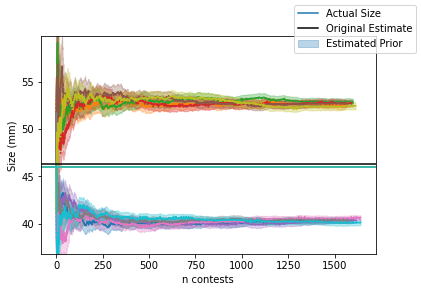

In [853]:
f0 = Fish(0,age=50)
f1 = Fish(1,age=50)

f2 = Fish(2,age=50)
f3 = Fish(3,age=50)
f4 = Fish(4,age=50)

fish_list = [Fish(f,size=46,age=50) for f in range(10)]

t0 = Tank(fish_list,f_method = 'random',f_outcome='escalate',n_fights=8000)
t0.print_status()
t0.run_all()
print('Running 1000 times...')
t0.print_status()

fig,ax = plt.subplots()

sizes = []
for i in range(len(t0.fishes)):
    f = t0.fishes[i]
    sizes.append(f.size)
    ax.plot(f.est_record,color=cm.tab10(i),linestyle=':')
    ax.plot(f.est_record_,color=cm.tab10(i))
    if i == 0:
        ax.axhline(f.size,color =cm.tab10(i),label='Actual Size')
        ax.fill_between(np.arange(len(f.est_record)),np.array(f.est_record_) + np.array(f.sdest_record),
                    np.array(f.est_record_) - np.array(f.sdest_record),
                    color=cm.tab10(i),alpha=.3,label='Estimated Prior')
    else:
        ax.axhline(f.size,color =cm.tab10(i))
        ax.fill_between(np.arange(len(f.est_record)),np.array(f.est_record_) + np.array(f.sdest_record),
                    np.array(f.est_record_) - np.array(f.sdest_record),
                    color=cm.tab10(i),alpha=.3)
    
ax.axhline(growth_func(50),color='black',label='Original Estimate')
ax.set_xlabel('n contests')
ax.set_ylabel('Size (mm)')
ax.set_ylim([min(sizes)*.8,max(sizes)*1.3])

fig.legend()
fig.show()

In [781]:
len(t0.fight_list)
t0.fight_list[10].outcome

1

/tmp/ipykernel_7584/1966186905.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(52.060670233417994, 2.353578462989098)

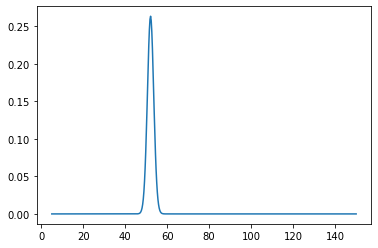

In [624]:
fig,ax = plt.subplots()

ax.plot(fish_list[0].xs,fish_list[0].prior)
fig.show()

fish_list[0].get_stats()

/tmp/ipykernel_7584/4235513086.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


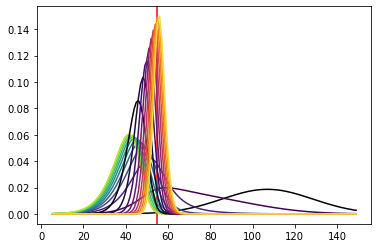

In [422]:
## How many losses does it take to become fixed in a new idea: 
## Answer: Depends a lot on the strength of your existing prior

xs = np.arange(5,150)
t = 1500
x_opp = 55
win = False
prior = prior_size(t,xs)

likelihood_w = define_likelihood(x_opp,xs,win=True)

likelihood_l = define_likelihood(x_opp,xs,win=False)

fig,ax = plt.subplots()
ax.plot(xs,prior,color='black')

ax.axvline(x_opp,color='red')
N = 10
for i in range(N):
    posterior = update(prior,likelihood_l)
    ax.plot(xs,posterior,color=cm.viridis(i/N))
    prior = posterior
    
for i in range(N):
    posterior = update(prior,likelihood_w)
    ax.plot(xs,posterior,color=cm.inferno(i/N))
    prior = posterior
fig.show()

34.231221276268755
21.56312625250501
21.56312625250501


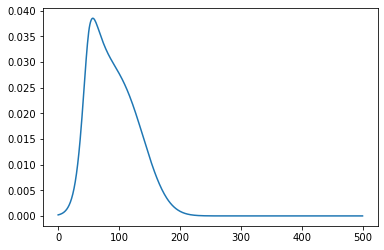

In [423]:
fig,ax = plt.subplots()
ax.plot(f1.prior)
print(f1.size)
print(f1.estimate)
print(f1.xs[np.argmax(f1.prior)])

47.65575439996869


/tmp/ipykernel_7584/1060894873.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


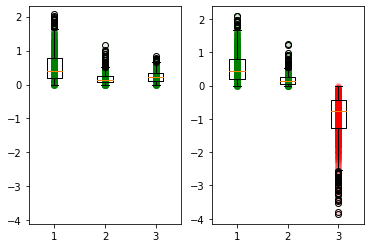

In [674]:
## expected, same expected, size-matched surprise
f1 = Fish()

print(f1.size)
## Note that because of the nature of objects, this will update the fish as you go

SHIFT_h = True
def win_win_lose(fish,opp_scale=.88,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(True,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(True,x_opp2)
    
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(False,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

def win_win_win(fish,opp_scale=.88,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(True,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(True,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(True,x_opp3)
    
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

N = 1000
fishes0 = []
win00,win01,loss02 = [],[],[]


fig,(ax1,ax0) = plt.subplots(1,2)
alph = .1

opp_scale = .88
for n in range(N):
    fishes0.append(Fish(n))
    shifts = win_win_lose(fishes0[n],opp_scale)
    win00.append(shifts[0])
    win01.append(shifts[1])
    loss02.append(shifts[2])
    
ax0.boxplot([win00,win01,loss02])
ax0.scatter([1]*N,win00,color='green',alpha=alph)
ax0.scatter([2]*N,win01,color='green',alpha=alph)
ax0.scatter([3]*N,loss02,color='red',alpha=alph)
#ax0.set_ylim([-1,1])


fishes1 = []
win10,win11,win12 = [],[],[]

for n in range(N):
    fishes1.append(Fish(n))
    shifts = win_win_win(fishes1[n],opp_scale)
    win10.append(shifts[0])
    win11.append(shifts[1])
    win12.append(shifts[2])
    

ax1.boxplot([win10,win11,win12])
ax1.scatter([1]*N,win10,color='green',alpha=alph)
ax1.scatter([2]*N,win11,color='green',alpha=alph)
ax1.scatter([3]*N,win12,color='green',alpha=alph)

ax1.set_ylim([-4.1,2.3])

fig.show()




40.72774321711426


/tmp/ipykernel_7584/2706600171.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


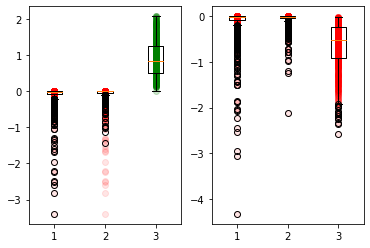

In [435]:
## expected, same expected, size-matched surprise
f1 = Fish(1)

print(f1.size)
## Note that because of the nature of objects, this will update the fish as you go
def lose_lose_win(fish,opp_scale=1.14,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(False,x_opp1)
    
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(False,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(True,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

def lose_lose_lose(fish,opp_scale=1.14,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(False,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(False,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(False,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

N = 1000
fishes0 = []
lose00,lose01,win02 = [],[],[]


fig,(ax0,ax1) = plt.subplots(1,2)
alph = .1

opp_scale = 1.50
for n in range(N):
    fishes0.append(Fish(n))
    shifts = lose_lose_win(fishes0[n],opp_scale)
    lose00.append(shifts[0])
    lose01.append(shifts[1])
    win02.append(shifts[2])
    
ax0.boxplot([lose00,lose01,win02])
ax0.scatter([1]*N,lose00,color='red',alpha=alph)
ax0.scatter([2]*N,lose00,color='red',alpha=alph)
ax0.scatter([3]*N,win02,color='green',alpha=alph)
#ax0.set_ylim([-1,1])


fishes1 = []
loss10,loss11,loss12 = [],[],[]

for n in range(N):
    fishes1.append(Fish(n))
    shifts = lose_lose_lose(fishes1[n],opp_scale)
    loss10.append(shifts[0])
    loss11.append(shifts[1])
    loss12.append(shifts[2])
    

ax1.boxplot([loss10,loss11,loss12])
ax1.scatter([1]*N,loss10,color='red',alpha=alph)
ax1.scatter([2]*N,loss11,color='red',alpha=alph)
ax1.scatter([3]*N,loss12,color='red',alpha=alph)
#ax1.set_ylim([-1,1])

fig.show()


In [556]:
from math import comb
import itertools,random

comb(3,2)

import itertools,random

    
matchup = random.choice(list(itertools.combinations(fish_list,2)))
print(matchup[0].name,matchup[1].name)

0 1


51.38907543508029
51.49810024404117


(4.649298597194388, 2.034068136272545, 2.324649298597194)

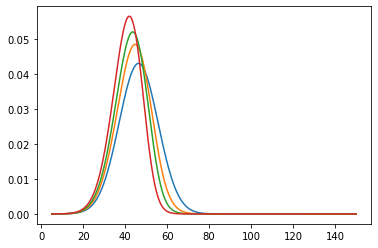

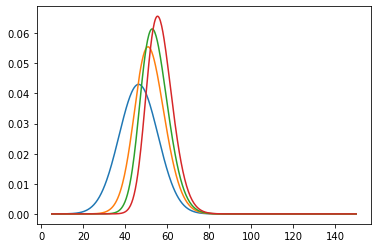

In [426]:
loser = Fish('george')
print(loser.size)
lose_lose_lose(loser,opp_scale=1.1,plot_me=True)

winner = Fish('barry')
print(winner.size)
win_win_win(winner,opp_scale=0.9,plot_me=True)

entropy from loss: 0.37202357790785967
shift from loss: -4.93987975951903
93.33667334669339 > 88.39679358717436
93.46647167633873 93.33667334669339
entropy from win 0.7181659259427353
shift from win: 4.9398797595190445
93.33667334669339 > 98.27655310621243


/tmp/ipykernel_7584/498811729.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


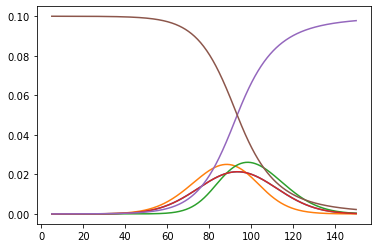

In [430]:
age = 200
loser = Fish('mitch',age=age,size=0)
winner = Fish('barack',age=age,size=0)

prior_l = loser.prior
est_l0 = loser.estimate
post_l,est_l1 = loser.update_prior(False,loser.size*1.1364)

post_l_ = loser.prior

fig,ax = plt.subplots()
ax.plot(loser.xs,prior_l)
ax.plot(loser.xs,post_l)


print("entropy from loss:",np.sum(rel_entr(prior_l,post_l)))
#print("same?",post_l == post_l_)

print("shift from loss:",est_l1 - est_l0)
print(est_l0,'>',est_l1)
print(winner.size,winner.estimate)
likelihood_w = define_likelihood(winner.estimate,winner.xs,True)
likelihood_l = define_likelihood(winner.estimate,winner.xs,False)

prior_w = winner.prior
est_w0 = winner.estimate

post_w,est_w1 = winner.update_prior(True,winner.size*0.88)
post_w_ = winner.prior
ax.plot(winner.xs,post_w)

ax.plot(winner.xs,prior_w)
ax.plot(winner.xs,likelihood_w/10)
ax.plot(winner.xs,likelihood_l/10)
fig.show()

print("entropy from win",np.sum(rel_entr(prior_w,post_w)))
#print("same?",post_w == post_w_)
print("shift from win:",est_w1 - est_w0)
print(est_w0,'>',est_w1)

/tmp/ipykernel_7584/3797804506.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


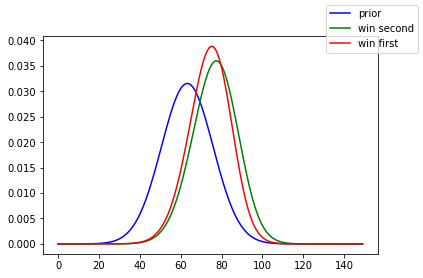

In [233]:
## Win, lose vs lose, win:
## Winning second is better (why is that? Is it always true?)

xs = np.arange(5,150)
t = 100
x_opp = 90
win = False
prior = prior_size(t,xs)

likelihood_w = np.zeros_like(prior)
likelihood_l = np.zeros_like(prior)

for s in range(len(likelihood)):
    likelihood_w[s] = likelihood_function_size(s,x_opp)  
    likelihood_l[s] = 1-likelihood_function_size(s,x_opp)
    
wl_post = update(prior,likelihood_w)
wl_post = update(wl_post,likelihood_l)

lw_post = update(prior,likelihood_l)
lw_post = update(prior,likelihood_w)

fig,ax = plt.subplots()

ax.plot(xs,prior,color='blue',label='prior')
ax.plot(xs,lw_post,color='green',label='win second')
ax.plot(xs,wl_post,color='red',label='win first')

fig.legend()
fig.show()


In [ ]:
## How long does the winner effect persist? 

# Win or lose the first fight, then 

/tmp/ipykernel_7584/1901349285.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


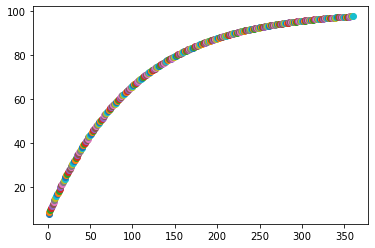

In [40]:
## Old stuff

def size(n_days):
    max_size = 100
    size = days / 5
    return size

def growth(s0):
    max_size = 100
    s1 = s0 + (max_size - s0) / 100
    return s1

s = 7
t = 0
fig,ax = plt.subplots()
while s < 100 and t < 360:
    t += 1
    s = growth(s)
    ax.scatter(t,s)
    
fig.show()

In [ ]:
## Growth is super complicated, for now, assume that, at any given point, there is no growth 
# I think a key insight here is going to be that variable growth is really what drives these dynamics.